### Motif
* Don't want to manually compute derivatives
* Want automatic computing of gradients

# [MyGrad](https://github.com/rsokl/MyGrad)
* Autograd library
 * similar to PyTorch
* Has graphs
 * Graphs not permanent like Tensorflow, get reset with nulling gradients

### Graph
* Consists of:
 * Operations
   * add, divide, arccosh, etc
   * contain references to Tensors used in the operation
   * create a Tensor
 * Tensors
   * contain data
   * flow between operations
   * contain a reference to creator operation (or None)
   * can also contain gradients
* Can be visualized with libraries
* Should **NOT** inadvertedly modify underlying ndarray
 * EXCEPT when operations need to be separated from the graph

### Autograd
* Autograd $\to$ auto-gradient
```python
x = tensor(z)
f = x ** z
f.backward()
>>>x.grad
4
```
* *x.backward()* computes $\dfrac{df}{dx}\biggr\rvert_x$
* Result: all tensors (execpt those defined as constants) now contain gradients (.grad)
* Computed nummerically, not equationally
* Propagates to all dependencies of x

# Application: Univ. Function Approximator
 * Regression problem
 * Not exactly a NN
 * $F(\vec x) = \sum\limits_{i=1}^{N}v_i\phi(\vec w \cdot \vec x + b_i)$
 * Let's fit a $\cos(x)$ function on $[-2\pi, 2\pi]$

In [1]:
import mygrad as mg
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_parameters(i, l1, l2):
    '''
    Creates parameters for a two-layer neural network with input size i, and layer sizes l1 and l2 
    '''
    w = mg.Tensor(np.random.randn(i, l1))
    b = mg.Tensor(np.random.randn(l1))
    v = mg.Tensor(np.random.randn(l1, l2))
    return (w, b, v)

In [3]:
from mygrad.nnet.activations import sigmoid
def forward_pass(x, params, func):
    w, b, v = params
    out1 = func(mg.matmul(x, w) + b)
    return mg.matmul(out1, v)

In [4]:
def l1_loss(pred, true):
    return mg.mean(mg.abs(pred-true))

In [5]:
def SGD(tensors, delta):
    for tensor in tensors:
        if tensor.grad is None:
            continue
        tensor.data -= delta*tensor.grad

In [6]:
# This cell preprocesses data and resets network parameters

N = 10

x = np.linspace(-2*np.pi, 2*np.pi, 1000).reshape(-1, 1)
y = np.cos(x)
idxs = np.arange(1000)

params = create_parameters(1, N, 1)

In [7]:
# This cell trains the network
# Testing data losses are printed below
# Re-run this cell to keep training

lr = 0.01
batch_sz = 40

for epoch in range(1000):
    np.random.shuffle(idxs)
    for idxs_batch in np.split(idxs, batch_sz):
        # forward pass
        x_batch = x[idxs_batch]
        y_batch = y[idxs_batch]
        y_pred_batch = forward_pass(x_batch, params, sigmoid)
        loss = l1_loss(y_pred_batch, y_batch)
        
        # backward pass
        loss.backward()
        SGD(params, lr)
        loss.null_gradients()
    if epoch % 100 == 0:
        # test
        y_pred = forward_pass(x, params, sigmoid)
        loss = l1_loss(y_pred, y)
        
        print(loss.item())
        loss.null_gradients()

1.3208071872301594
0.38829232273943703
0.21442604182202502
0.12404815775960919
0.06548413426792006
0.031029824947299993
0.03402880858331856
0.041029960656370115
0.020528412205669696
0.03079238444674499


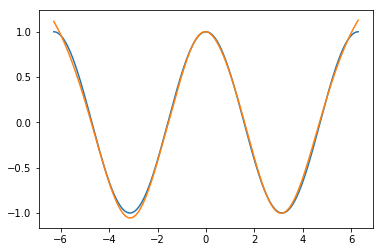

In [8]:
y_pred = forward_pass(x, params, sigmoid)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, y_pred)

### Problems!!!
* Does not fit at ends
 * not enough data points
 * no points to left or right
* If range is extended, function on the outside is garbage
* If $[-2\pi, 2\pi]$ is extended to $[-6\pi, 6\pi]$, takes a long time to fit
 * Possible solution: normalize

# Application: Tendril Classificator
* Classification problem
 * output layer represents probability of classes
 * input is 2d
 * output is 3d
* $F(\vec x) = \sum\limits_{i=1}^{N}v_i\phi(\vec w \cdot \vec x + b_i)$
* Let's use ReLU as our activation function

In [9]:
from datasets import ToyData
from mygrad.nnet.activations import relu
from mygrad.nnet.losses import softmax_crossentropy

`datasets module: datasets will be loaded from 'C:\Users\aleks_000\datasets'


In [10]:
def accuracy(predictions, truth):
    return np.mean(np.argmax(predictions, axis=1)==truth)

In [11]:
# This cell preprocesses data and resets network parameters

N = 25

dims = 2     # dimensionality of input
tendrils = 3 # dimensionality of output
data = ToyData(num_classes=tendrils, dimensionality=dims)
xtrain, ytrain, xtest, ytest = data.load_data()

idxs = np.arange(xtrain.shape[0])

params = create_parameters(dims, N, tendrils)

<IPython.core.display.Javascript object>


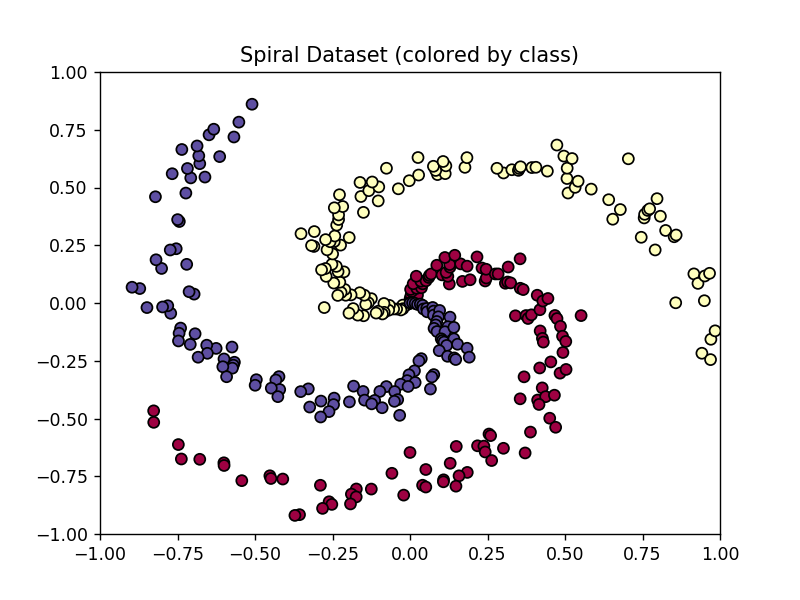

In [12]:
%matplotlib notebook
fig, ax = data.plot_spiraldata()

In [13]:
# This cell trains the network
# Testing data accuracies are printed below
# Re-run this cell to keep training

lr = 0.1
batch_sz = 25

for epoch in range(1000):
    np.random.shuffle(idxs)
    for idxs_batch in np.split(idxs, batch_sz):
        # forward pass
        x_batch = xtrain[idxs_batch]
        y_batch = ytrain[idxs_batch]
        y_pred_batch = forward_pass(x_batch, params, relu)
        loss = softmax_crossentropy(y_pred_batch, y_batch)
        
        # backward pass
        loss.backward()
        SGD(params, lr)
        loss.null_gradients()
    if epoch % 100 == 0:
        # test
        y_pred = forward_pass(xtest, params, relu)
        acc = accuracy(y_pred, ytest)
        
        print(acc)

0.583333333333
0.883333333333
0.916666666667
0.916666666667
0.95
0.966666666667
0.933333333333
0.916666666667
0.95
0.95


<IPython.core.display.Javascript object>


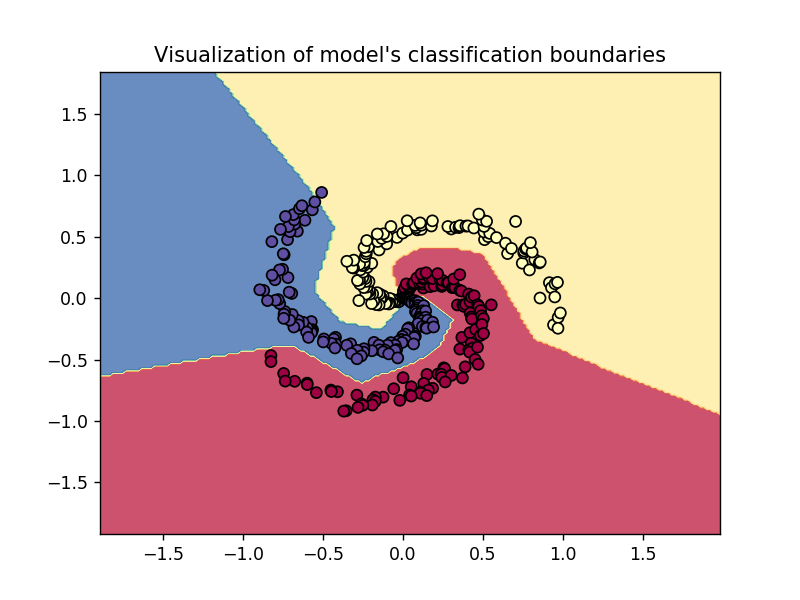

In [14]:
def dummy_function(x):
    from mygrad.nnet.activations import softmax
    return softmax(forward_pass(x, params, relu)).data

fig, ax = data.visualize_model(dummy_function, entropy=False);